In [129]:
import colorsys
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [130]:
# original-dataset\\GlobalTVBC\\css\\23579edb1e12f906d2b83f522d1c27011dc1b1d8.css
with open("minified-dataset\\Facebook\\index_files\\1GsqYFnXaZQ.css", "rb") as file:
    css_text_test = file.read().decode(errors="replace")

In [131]:
def getSelectorStyleMap(styles):
    styles = np.array(styles.split("{"))
    styles = list(map(lambda selectorStyle: selectorStyle.split("}"), styles))
    styles = [j for sub in styles for j in sub] # empty string means end of an at rule
    
    selectorToStyle = {}
    mediaQuery = ""
    atRule = ""
    isSelector = True

    for i, cssComponent in enumerate(styles):
        if "@media" in cssComponent:
            mediaQuery = cssComponent
            continue
        elif "@" in atRule:
            atRule = cssComponent
            continue

        if isSelector:
            selectorToStyle[cssComponent] = None
            isSelector = False
        else:
            selectorToStyle[styles[i-1]] = {
                "style": list(map(lambda x: x.split(":"), cssComponent.split(";"))),
                "atRule": atRule,
                "mediaQuery": mediaQuery
            }
            isSelector = True

    del selectorToStyle[""]

    return selectorToStyle

In [132]:
testStyleMap = getSelectorStyleMap(css_text_test)
testStyleMap

{'form': {'style': [['margin', '0'], ['padding', '0']],
  'atRule': '',
  'mediaQuery': ''},
 'label': {'style': [['cursor', 'pointer'],
   ['color', '#666'],
   ['font-weight', 'bold'],
   ['vertical-align', 'middle']],
  'atRule': '',
  'mediaQuery': ''},
 'label input': {'style': [['font-weight', 'normal']],
  'atRule': '',
  'mediaQuery': ''},
 'textarea,.inputtext,.inputpassword': {'style': [['border',
    '1px solid #bdc7d8'],
   ['margin', '0'],
   ['padding', '3px'],
   ['-webkit-appearance', 'none'],
   ['-webkit-border-radius', '0']],
  'atRule': '',
  'mediaQuery': ''},
 'textarea': {'style': [['max-width', '100%']],
  'atRule': '',
  'mediaQuery': ''},
 'select': {'style': [['border', '1px solid #bdc7d8'], ['padding', '2px']],
  'atRule': '',
  'mediaQuery': ''},
 '.inputtext,.inputpassword': {'style': [['padding-bottom', '4px']],
  'atRule': '',
  'mediaQuery': ''},
 '.inputtext:invalid,.inputpassword:invalid': {'style': [['-webkit-box-shadow',
    'none']],
  'atRule': ''

In [133]:
def colorToHexCode(value):
    try:
        # error is caused with gradients
        if "hsla" in value or "rgba" in value:
            return value

        # seperate hsl or rgb args
        value = value.replace("%", "")
        colors = [int(x) for x in value[value.find("(")+len("("):value.rfind(")")].split(",")]

        # if hsl convert to rgb
        if "hsl" in value:
            h, s, l = colors
            h = h/360
            s = s/100
            l = l/100
            colors = colorsys.hls_to_rgb(h, l, s)
            colors = [int(round(x*255.0)) for x in colors]

        # convert rgb to hexcode
        colors = list(map(lambda color: str(hex(color).split('x')[-1][-2:]).zfill(2), colors))
        colors = "".join(colors)

        return f"#{colors}"
    except:
        return value

In [134]:
def seperateSizeValues(values):
    values = values.replace(" ", "")
    values = values.replace("auto", "1auto")

    seperatedValues = []
    value = ""
    isUnit = False

    for char in values:
        if isUnit and char.isdigit():
            isUnit = False
            seperatedValues.append(value)
            value = ""

        value = f"{value}{char}"

        if not char.isdigit():
            isUnit = True

    seperatedValues.append(value)

    return [x if x != "1auto" else "auto" for x in seperatedValues]

In [135]:
seperateSizeValues("20px auto 20px 10px")

['20px', 'auto', '20px', '10px']

In [139]:
def sizeShortHandToLongHand(attr, seperatedValues):
    try:
        fourPosArgs = [["top"], ["right"], ["bottom"], ["left"]]
        threePosArgs = [["top"], ["left", "right"], ["bottom"]]
        twoPosArgs = [["top", "bottom"], ["left", "right"]]

        posArgs = [twoPosArgs, threePosArgs, fourPosArgs][len(seperatedValues)-2]

        longHand = []

        for i, pos in enumerate(posArgs):
            for posName in pos:
                longHand.append([f"{attr}-{posName}", seperatedValues[i]])

        return longHand
    except:
        return None

In [140]:
sizeShortHandToLongHand("padding", seperateSizeValues("20px25%31px21vw"))

[['padding-top', '20px'],
 ['padding-right', '25%'],
 ['padding-bottom', '31px'],
 ['padding-left', '21vw']]

In [142]:
sizeShortHandToLongHand("padding", seperateSizeValues("0"))

In [141]:
def normalizeStyle(attr, value):
    isMultiSelectorChange = False

    if "color" in attr:
        if not "#" in value:
           value = colorToHexCode(value)
    elif attr == "margin" or attr == "padding":
        isMultiSelectorChange = True
        seperateValues = seperateSizeValues(value)

        if seperateValues:
            isMultiSelectorChange = False
            attr, value = None, sizeShortHandToLongHand(attr, seperateValues)

    return attr, value, isMultiSelectorChange

for selector in testStyleMap:
    if selector:
        for i, x in enumerate(testStyleMap[selector]["style"]):
            try:
                attr, value = x
                a, v, isMultiSelectorChange = normalizeStyle(attr, value)

                if isMultiSelectorChange:
                    del attr, value
                    testStyleMap[selector]["style"].extend(v)
                else:
                    attr, value = a, v
            except:
                pass


if "" in testStyleMap:
    del testStyleMap[""]

In [144]:
testStyleMap

{'form': {'style': [['margin', '0'], ['padding', '0']],
  'atRule': '',
  'mediaQuery': ''},
 'label': {'style': [['cursor', 'pointer'],
   ['color', '#666'],
   ['font-weight', 'bold'],
   ['vertical-align', 'middle']],
  'atRule': '',
  'mediaQuery': ''},
 'label input': {'style': [['font-weight', 'normal']],
  'atRule': '',
  'mediaQuery': ''},
 'textarea,.inputtext,.inputpassword': {'style': [['border',
    '1px solid #bdc7d8'],
   ['margin', '0'],
   ['padding', '3px'],
   ['-webkit-appearance', 'none'],
   ['-webkit-border-radius', '0']],
  'atRule': '',
  'mediaQuery': ''},
 'textarea': {'style': [['max-width', '100%']],
  'atRule': '',
  'mediaQuery': ''},
 'select': {'style': [['border', '1px solid #bdc7d8'], ['padding', '2px']],
  'atRule': '',
  'mediaQuery': ''},
 '.inputtext,.inputpassword': {'style': [['padding-bottom', '4px']],
  'atRule': '',
  'mediaQuery': ''},
 '.inputtext:invalid,.inputpassword:invalid': {'style': [['-webkit-box-shadow',
    'none']],
  'atRule': ''

In [ ]:
def getStyleText(styleMap):
    selectorStyles = [styleMap[key]["style"] for key in styleMap if not styleMap[key]["atRule"] and not styleMap[key]["mediaQuery"]]
    styles = []

    for selectorStyle in selectorStyles:
        style = ""
        for attr, value in selectorStyle:
            style += f"{attr}: {value}; "
        style = style.strip()

        styles.append(style)

    return styles

In [ ]:
testStyles = getStyleText(testStyleMap)

In [ ]:
testStyles[:3]

['margin: 0; padding: 0;',
 'cursor: pointer; color: #666; font-weight: bold; vertical-align: middle;',
 'font-weight: normal;']

In [ ]:
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(testStyles)

Iteration: 435/517
C:\Users\mattg_3roa89k\AppData\Local\Temp\ipykernel_16676\36860394.py:6: ConvergenceWarning: Number of distinct clusters (435) found smaller than n_clusters (436). Possibly due to duplicate points in X.
  km = km.fit(X)

In [ ]:
Sum_of_squared_distances = []
K = range(2,435)

for k in K:
    km = KMeans(n_clusters=k, max_iter=150, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    print(f"Iteration: {k}/435", end="\r")

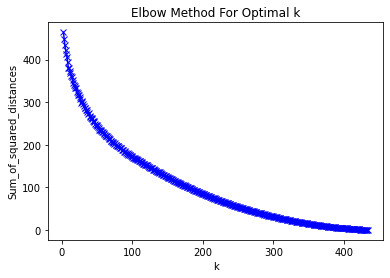

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# rerunning this without the above cells will change the output values
selector = list(testStyleMap.keys())

true_k = 200
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels = model.labels_

In [ ]:
selector_styles_df = pd.DataFrame(list(zip(selector,labels)),columns=['selector','cluster'])
selector_styles_df = selector_styles_df.sort_values(by=['cluster'])
print(selector_styles_df)

                                              selector  cluster
334                                               .pls        0
337                                               .phs        0
355                                               .mls        0
78                                              ._5fyj        0
385                                      ._4ki._704>li        0
..                                                 ...      ...
273  .uiButton,.uiButtonSuppressed:active,.uiButton...      199
227                                 ._50zz._50z-:hover      199
228                   ._50zz._50z-:active,._50zz._42fs      199
226                                       ._50zz._50z-      199
91                                          .sp_8jd5ay      199

[517 rows x 2 columns]


In [ ]:
selector_styles_df.values.tolist()

[['.pls', 0],
 ['.phs', 0],
 ['.mls', 0],
 ['._5fyj', 0],
 ['._4ki._704>li', 0],
 ['._4g4y', 1],
 ['.mbm', 1],
 ['.mvm', 1],
 ['.mam', 1],
 ['.mtm', 1],
 ['._5a8u', 2],
 ['._4-i0', 2],
 ['._7lt ._7lw', 2],
 ['._4-i2:first-child', 2],
 ['._4-i2:last-child', 2],
 ['._4-i2:only-child', 2],
 ['._4-hz', 2],
 ['._50-0._50z_:hover', 3],
 ['._50-0._50z_', 3],
 ['._50-0._50z-:hover', 3],
 ['._50-0._50z-', 3],
 ['._50-0._50z-:active,._50-0._42fs', 3],
 ['._53ip ._53im ._53io', 3],
 ['._53ip ._53in ._53io', 3],
 ['.uiToggleFlyout,.toggleTargetClosed,.openToggler .uiToggleFlyout .uiToggleFlyout',
  4],
 ['._53ih ._53io', 4],
 ['.pop_content .dialog_loading,.dialog_loading_shown .dialog_title,.dialog_loading_shown .dialog_content',
  4],
 ['#facebook .hidden_elem', 4],
 ['.omitDialogFooter .pop_content .dialog_body', 5],
 ['.noborder', 5],
 ['abbr', 5],
 ['.topborder', 5],
 ['.bottomborder', 5],
 ['._54rv', 6],
 ['.uiHeaderPage .uiHeaderTitle', 7],
 ['.pvl', 7],
 ['.fb_content', 7],
 ['._4kg._703>l

In [ ]:
clusteredSelectors = selector_styles_df.values.tolist()
clusterSelectorMap = {}

for selector, clusterIndex in clusteredSelectors:
    if str(clusterIndex) in clusterSelectorMap:
        clusterSelectorMap[str(clusterIndex)].append(selector)
    else:
        clusterSelectorMap[str(clusterIndex)] = [selector]

In [ ]:
def saveAsJson(filePath, data):
    with open(filePath, 'w') as fp:
        json.dump(data, fp, indent=2)

In [ ]:
saveAsJson("selectors-clustered.json", selector_styles_df.values.tolist())

In [ ]:
def displayCluster(clusterIndex):
    for selector in clusterSelectorMap[str(clusterIndex)]:
        print(selector, testStyleMap[selector])

In [ ]:
displayCluster(0)

.pls {'style': [['padding-left', '5px']], 'atRule': '', 'mediaQuery': ''}
.phs {'style': [['padding-left', '5px'], ['padding-right', '5px']], 'atRule': '', 'mediaQuery': ''}
.mls {'style': [['margin-left', '5px']], 'atRule': '', 'mediaQuery': ''}
._5fyj {'style': [['background-color', 'rgba(0,0,0,.5)'], ['left', '0'], ['padding', '5px 0 5px 5px'], ['position', 'absolute'], ['top', '0'], ['width', '99%']], 'atRule': '', 'mediaQuery': ''}
._4ki._704>li {'style': [['padding-left', '5px'], ['padding-right', '5px']], 'atRule': '', 'mediaQuery': ''}


In [ ]:
displayCluster(101)

.pop_content .dialog_content.dialog_content_titleless {'style': [['border-top', '1px solid #555']], 'atRule': '', 'mediaQuery': ''}
.pop_content .dialog_content {'style': [['background', '#fff'], ['border', '1px solid #555'], ['border-top-width', '0']], 'atRule': '', 'mediaQuery': ''}
._13,._14 {'style': [['border-color', '#555'], ['border-style', 'solid'], ['border-width', '0 1px']], 'atRule': '', 'mediaQuery': ''}


In [ ]:
unsortedCombinedStyleMap = {}

for clusterIndex in clusterSelectorMap:
    for selector in clusterSelectorMap[clusterIndex]:
        
        